In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
import numpy as np
from sklearn import tree, preprocessing
import pickle
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

data = pd.read_csv ('D:/NLP_Data/Data4Test.csv', encoding='ISO-8859-1')

0    93
1    57
Name: Label, dtype: int64


C:\Users\tunji\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

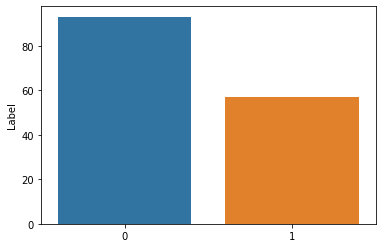

In [39]:
#Check the ratio of desired response[1] to undesired responses[0]

x=data['Label'].value_counts()
print(x)
sns.barplot(x.index,x)

In [40]:
#Function to make sure the responses labelled [0] those labelled [1] are ballanced
#Function to balance the class
#Arguments => data, catColum -> name of column of the scores i.e. label
# cat_high -> the category of score that is higher i.e. [0]
# cat_low -> the category of score that is lower i.e. [1]
#Ballancing technique is -> downsampling (disadvantage is that we will loose some of our training data)

def balanceClassCategory (data, catColumn, cat_high, cat_low):
    #shuffled = df.sample(frac=1).reset_index()
    df = data.sample(frac=1).reset_index()
    df_cat_high= df[df['Label']== cat_high]
    df_cat_low = df[df['Label']== cat_low]
    df_cat_high_downsampled = df_cat_high.sample(df_cat_low.shape[0])
    df_balanced = pd.concat([df_cat_high_downsampled, df_cat_low])
    
    shuffled = df_balanced.sample(frac=1)
    return shuffled

In [41]:
# balanceClassCategory function on the data
data = balanceClassCategory (data, "Label", 0, 1)

1    57
0    57
Name: Label, dtype: int64


C:\Users\tunji\anaconda3\envs\nlp\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='Label'>

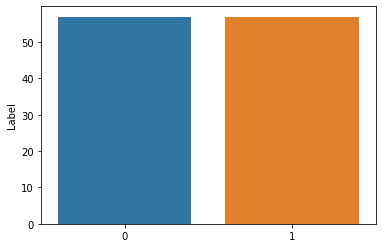

In [42]:
#Visualize the balanced data
x=data['Label'].value_counts()
print(x)
sns.barplot(x.index,x)

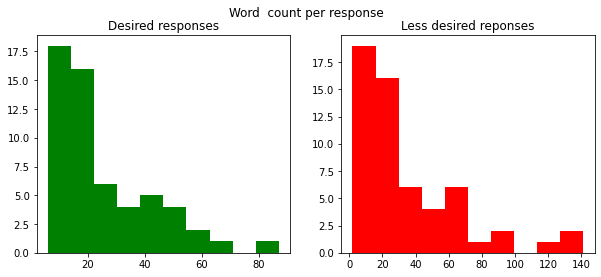

In [43]:
#Vsualize relevant information about our data
#for example here we visualize word-count of responses
#we compare between desired[1] and less-desired[0] responses

data['word_count'] = data['Response'].apply(lambda x: len(str(x).split()))
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words=data[data['Label']==1]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Desired responses')
train_words=data[data['Label']==0]['word_count']
ax2.hist(train_words,color='red')
ax2.set_title('Less desired reponses')
fig.suptitle('Word  count per response')
plt.show()

#plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/wordCountPerRespsonseIn_0_1.jpg')

In [44]:
def preprocesing_1(In_data):
    dataRespList = In_data['Response'].tolist()
    dataLabelList = In_data['Label'].tolist()
    allowed_word_type = ["J", "R", "V"]
    
    stop_words = list(set(stopwords.words('english')))
    cleanResp =[]
    LabelList=[]
    OriginalResp =[]
    for resp, lb in zip(dataRespList, dataLabelList):
        # Remove special characters
        temp = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in resp.split("\n")]
        cleaned = ' '.join(map(str,  temp))
        #cleaned = re.sub(r'[^\w\s]','',resp)
        OriginalResp.append(cleaned)
        
        tokenized = word_tokenize(cleaned)
        stopped = [w for w in tokenized if not w in stop_words]
        pos = nltk.pos_tag(stopped)
        all_words = []
        
        for w in pos:
            if w[1][0] in allowed_word_type:
                all_words.append(w[0].lower())
        joinedToken = ' '.join(map(str,all_words))
        cleanResp.append(joinedToken)
        LabelList.append(lb)
    
    data2 = pd.DataFrame(np.array(OriginalResp).T)
    data2.columns = ['Response']
    data2["clean_text"] = pd.DataFrame(np.array(cleanResp).T)
    data2['Label'] = pd.DataFrame(np.array(LabelList).T)
    
    return data2

In [45]:
#Preprocess the data to remove punctuations and stop words
#the Brown Corpus text contains specific punctuation sequences 
#( `,and``) that should be removed. You can do that by adding the character sequences 
#to the list of stop words (easier than adding characters to the punctuation module)

nlp = spacy.load("en_core_web_sm")

nlp.Defaults.stop_words.add("`,")
nlp.Defaults.stop_words.add("``")

In [46]:

wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [47]:
#Lematizaton that works with string 
#Return string of all the tokens, separated by spaces.
#nltk.download()

def lemmatizeWorkingWithStrings(text):
    temp = [re.sub(r"[^a-zA-Z0-9]+", ' ', k) for k in text.split("\n")]
    cleaned = ' '.join(map(str,  temp))
    doc = nlp(cleaned)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]
    word_pos_tags = nltk.pos_tag(tokens) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return ' '.join(a)

In [48]:
#Remove puctuation and stop words, stem and lemmatize data
#data['clean_text'] = data['Response'].apply(lambda x: lemmatizeWorkingWithStrings(x))

data = preprocesing_1(data)

In [49]:
data.head(100)
#data.to_csv('D:/NLP_SentimentA_RTE_Data/Images/testClean2.csv', index= True)

,Response,clean_text,Label
0,I love how you took the time to set this probl...,love took set easy solve apprecieat hard put set,1
1,I would make the correction playful asking the...,make playful asking aligned using convey posit...,1
2,Kanye let us go through how you solved this,let go solved,1
3,I would give encouragement and ask him to show...,give thought want guide recognize put wrong ex...,1
4,I would tell him to align the numbers better s...,tell align better easier made mistake,0
...,...,...,...
95,You are close Recheck your arithmetic,close,1
96,First I would praise him for his attempted sol...,praise attempted then ask prompt explain logic...,1
97,Are you sure you have layed out the problem co...,sure layed correctly,0
98,This is almost correct but you have a small er...,almost correct small started,0


In [50]:
#function splits data into X_train, X_test -> [clean_text], y_train, y_test-> [Label] 
#stratify to ensure even distribution of responses labeled [0] or [1] in you train and test data

def splitDataToTrainAndTest(In_data, testDataPercentage):
    
    X_train, X_test, y_train, y_test = train_test_split(In_data["clean_text"],In_data["Label"],test_size=testDataPercentage,shuffle=True,stratify=In_data['Label'])
    
    return  X_train, X_test, y_train, y_test

In [51]:
#model vectorizes the test data
def vectorizeXtrainAndX_test(In_X_train, In_X_test):
   
        
    tfidf_vectorizer = TfidfVectorizer(use_idf=True)
    X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(In_X_train) 
    X_test_vectors_tfidf = tfidf_vectorizer.transform(In_X_test)
    
    return X_train_vectors_tfidf, X_test_vectors_tfidf

In [52]:
def trainAndTest_lr_Model(In_X_train_vectors_tfidf, In_X_test_vectors_tfidf,In_X_test, In_y_train, In_y_test):
    
    #X_train, X_test, y_train, y_test = splitDataToTrainAndTest(In_data)
    
    #X_train_vectors_tfidf, X_test_vectors_tfidf = vectorizeXtrainAndX_test(X_train, X_test)
    
   
    lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
    
    lr_tfidf.fit(X_train_vectors_tfidf, In_y_train)
    
    y_predict = lr_tfidf.predict(X_test_vectors_tfidf)

    y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

    report_lr = classification_report(In_y_test, y_predict, output_dict=True)
    
    cm = confusion_matrix(In_y_test, y_predict)
    acc = accuracy_score(In_y_test, y_predict)
    f1= f1_score(In_y_test, y_predict)
    recall=recall_score(In_y_test, y_predict)
        
        
    
    
    #print(classification_report(In_y_test, y_predict))
    
    #print('Confusion Matrix:',confusion_matrix(In_y_test, y_predict))
    
    #fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    #roc_auc = auc(fpr, tpr)
    #listOfX_testValues = X_test.values.tolist()
    #rawDatabased_on_testData = In_data[In_data['clean_text'].isin(listOfX_testValues)]
    #raw_X_testData=rawDatabased_on_testData['Response']
    
    #nReport = pd.DataFrame(raw_X_testData)
    #nReport['clean_text']=X_test
    #nReport["Human Label"] = y_test
    #nReport["LogisticReg Prediction"] = y_predict
    #nReport.to_csv('D:/NLP_SentimentA_RTE_Data/Images/lr/'+'lr'+str(runNum)+'.csv', index= True)
    
    #filename = 'C:/Users/tunji/CMUProject/SavedModels/lrModel'+str(runNum)+'.sav'
    #pickle.dump(lr_tfidf, open(filename, 'wb'))
    #print('AUC:', roc_auc)
    #print ("Accuracy", accuracy_score(In_y_test, y_predict))
    #print ("F1-Score", f1_score(In_y_test, y_predict))
    
    #print ("Recall", recall_score(In_y_test, y_predict))
    
    return acc, f1, recall, cm, y_predict,In_y_train, In_X_test, lr_tfidf

In [53]:
def trainAndTest_nb_Model(In_X_train_vectors_tfidf, In_X_test_vectors_tfidf,In_X_test, In_y_train, In_y_test):
    
    #X_train, X_test, y_train, y_test = splitDataToTrainAndTest(In_data)
    
    #X_train_vectors_tfidf, X_test_vectors_tfidf = vectorizeXtrainAndX_test(X_train, X_test)
   
    nb_tfidf = MultinomialNB()

    nb_tfidf.fit(X_train_vectors_tfidf, In_y_train)
    
    y_predict = nb_tfidf.predict(X_test_vectors_tfidf)

    y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

    report_lr = classification_report(In_y_test, y_predict, output_dict=True)
    
    cm = confusion_matrix(In_y_test, y_predict)
    acc = accuracy_score(In_y_test, y_predict)
    f1= f1_score(In_y_test, y_predict)
    recall=recall_score(In_y_test, y_predict)
        
        
        
    
   
    return acc, f1, recall, cm, y_predict, In_y_train, In_X_test, nb_tfidf

In [54]:
def trainAndTest_SVM_Model(In_X_train_vectors_tfidf, In_X_test_vectors_tfidf,In_X_test, In_y_train, In_y_test):
    
    #X_train, X_test, y_train, y_test = splitDataToTrainAndTest(In_data)
    
    #X_train_vectors_tfidf, X_test_vectors_tfidf = vectorizeXtrainAndX_test(X_train, X_test)
    
   
    SVM = svm.SVC(C=1.0, kernel = 'linear', degree=3, gamma='auto')
    SVM.fit(X_train_vectors_tfidf, In_y_train)
    y_predict = SVM.predict(X_test_vectors_tfidf)

    #y_prob = nb_tfidf.predict_proba(In_X_test_vectors_tfidf)[:,1]
    report_nb = classification_report(In_y_test, y_predict, output_dict=True)
        
    cm = confusion_matrix(In_y_test, y_predict)
    acc = accuracy_score(In_y_test, y_predict)
    f1= f1_score(In_y_test, y_predict)
        
    recall=recall_score(In_y_test, y_predict)
        
        
    
    #print(classification_report(In_y_test, y_predict))
    
    #print('Confusion Matrix:',confusion_matrix(In_y_test, y_predict))
    
    #fpr, tpr, thresholds = roc_curve(In_y_test, y_prob)
    
    #roc_auc = auc(fpr, tpr)
    
    #listOfX_testValues = X_test.values.tolist()
    #rawDatabased_on_testData = In_data[In_data['clean_text'].isin(listOfX_testValues)]
    #raw_X_testData=rawDatabased_on_testData['Response']
    
    #nReport = pd.DataFrame(raw_X_testData)
    #nReport['clean_text']=X_test
    #nReport["Human Label"] = y_test
    #nReport["SVM Prediction"] = y_predict
    #nReport.to_csv('D:/NLP_SentimentA_RTE_Data/Images/svm/'+'SVM'+str(runsNum)+'.csv', index= True)
    
    #filename = 'C:/Users/tunji/CMUProject/SavedModels/svmModel'+str(runsNum)+'.sav'
    #pickle.dump(SVM, open(filename, 'wb'))
    #print('AUC:', roc_auc)
    #print ("Accuracy", accuracy_score(In_y_test, y_predict))
    #print ("F1-Score", f1_score(In_y_test, y_predict))
    
    #print ("Recall", recall_score(In_y_test, y_predict))
    
    return acc, f1, recall, cm, y_predict, In_y_train, In_X_test, SVM

In [55]:
def trainAndTest_tree_Model(In_X_train_vectors_tfidf, In_X_test_vectors_tfidf, In_X_test, In_y_train, In_y_test):
    
    treeModel = tree.DecisionTreeClassifier()
    treeModel= treeModel.fit(X_train_vectors_tfidf, In_y_train)
    y_predict = treeModel.predict(X_test_vectors_tfidf)
        
    report_nb = classification_report(In_y_test, y_predict, output_dict=True)
        
    cm = confusion_matrix(In_y_test, y_predict)
        
    acc = accuracy_score(In_y_test, y_predict)
        
    f1= f1_score(In_y_test, y_predict)
        
    recall=recall_score(In_y_test, y_predict)
        
        
    
    #listOfX_testValues = X_test.values.tolist()
    #awDatabased_on_testData = In_data[In_data['clean_text'].isin(listOfX_testValues)]
    #raw_X_testData=rawDatabased_on_testData['Response']
    
    #nReport = pd.DataFrame(raw_X_testData)
    #nReport['clean_text']=X_test
    #nReport["Human Label"] = y_test
    #nReport["Decission Tree Prediction"] = y_predict
    
    #nReport.to_csv('D:/NLP_SentimentA_RTE_Data/Images/tree/'+'tree'+str(runsNum)+'.csv', index= True)
    
    #filename = 'C:/Users/tunji/CMUProject/SavedModels/treeModel'+str(runsNum)+'.sav'
    #pickle.dump(treeModel, open(filename, 'wb'))
    
    return acc, f1, recall, cm, y_predict, In_y_train, In_X_test, treeModel
    

In [56]:

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [57]:

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)


In [58]:
def trainAndTest_BERT_Model(In_X_train, In_X_test, In_y_train, In_y_test):
    model = tf.keras.Model(inputs=[text_input], outputs = [l])
    
    METRICS = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS)
    
    model.fit(In_X_train, In_y_train, epochs=10)
    
    y_predict = model.predict(In_X_test)
    y_predict = y_predict.flatten()
    y_predict = np.where(y_predict > 0.5, 1, 0)
    
    report_BERT = classification_report(In_y_test, y_predict, output_dict=True)
    
    cm = confusion_matrix(In_y_test, y_predict)
        
    acc = accuracy_score(In_y_test, y_predict)
        
    f1= f1_score(In_y_test, y_predict)
        
    recall=recall_score(In_y_test, y_predict)
    
    
    return acc, f1, recall, cm, y_predict,In_y_train, In_X_test, model
    

In [59]:
#acc_lr, f1_lr, recall_lr,cm_lr=trainAndTest_lr_Model(X_train_vectors_tfidf, X_test_vectors_tfidf)

In [60]:
#X_train, X_test, y_train, y_test= splitDataToTrainAndTest(data2, 0.5)

In [61]:
#model.fit(X_train, y_train, epochs=10)

In [62]:
# X_train, X_test, y_train, y_test= splitDataToTrainAndTest(data2, 0.5)

In [63]:
#acc_BERT, f1_BERT, recall_BERT,cm_BERT=trainAndTest_BERT_Model(X_train, X_test, y_train, y_test)

In [64]:
#y_predicted = y_predicted.flatten()
#y_predict = np.where(y_predicted > 0.5, 1, 0)
#y_predic
X_train, X_test, y_train, y_test= splitDataToTrainAndTest(data, 0.5)
    
acc_BERT, f1_BERT, recall_BERT, cm_BERT, y_predict_BERT,y_train_BERT, X_test_BERT, model_BERT=trainAndTest_BERT_Model(X_train, X_test, y_train, y_test)

Epoch 1/10
2/2 [==============================] - 24s 5s/step - loss: 0.7173 - accuracy: 0.5263 - precision: 0.5200 - recall: 0.4643
Epoch 2/10
2/2 [==============================] - 10s 4s/step - loss: 0.7177 - accuracy: 0.4561 - precision: 0.4681 - recall: 0.7857
Epoch 3/10
2/2 [==============================] - 10s 5s/step - loss: 0.7156 - accuracy: 0.4912 - precision: 0.4857 - recall: 0.6071
Epoch 4/10
2/2 [==============================] - 10s 4s/step - loss: 0.7058 - accuracy: 0.5088 - precision: 0.5000 - recall: 0.3929
Epoch 5/10
2/2 [==============================] - 9s 4s/step - loss: 0.6686 - accuracy: 0.5088 - precision: 0.5000 - recall: 0.1429
Epoch 6/10
2/2 [==============================] - 10s 4s/step - loss: 0.6997 - accuracy: 0.4912 - precision: 0.4706 - recall: 0.2857
Epoch 7/10
2/2 [==============================] - 10s 4s/step - loss: 0.7003 - accuracy: 0.4737 - precision: 0.4500 - recall: 0.3214
Epoch 8/10
2/2 [==============================] - 10s 4s/step - loss: 

In [65]:
#for i in range(10):
    #X_train, X_test, y_train, y_test= splitDataToTrainAndTest(data2, 0.5)
#X_train, X_test, y_train, y_test= splitDataToTrainAndTest(data, 0.5)
    
X_train_vectors_tfidf, X_test_vectors_tfidf= vectorizeXtrainAndX_test(X_train, X_test)
    
    
acc_lr, f1_lr, recall_lr, cm_lr, y_predict_lr,y_train_lr, X_test_lr, model_lr =trainAndTest_lr_Model(X_train_vectors_tfidf, X_test_vectors_tfidf, X_test, y_train, y_test)

acc_nb, f1_nb, recall_nb, cm_nb, y_predict_nb, y_train_nb, X_test_nb, model_nb=trainAndTest_nb_Model(X_train_vectors_tfidf, X_test_vectors_tfidf,X_test, y_train, y_test)

acc_svm, f1_svm, recall_svm, cm_svm, y_predict_svm, y_train_svm, X_test_svm, model_svm=trainAndTest_SVM_Model(X_train_vectors_tfidf, X_test_vectors_tfidf,X_test, y_train, y_test)

acc_tree, f1_tree, recall_tree, cm_tree, y_predict_tree, y_train_tree, X_test_tree, model_tree=trainAndTest_tree_Model(X_train_vectors_tfidf, X_test_vectors_tfidf,X_test, y_train, y_test)
    
print(acc_lr, acc_nb, acc_svm, acc_tree, acc_BERT)

0.543859649122807 0.6140350877192983 0.5614035087719298 0.5263157894736842 0.5964912280701754


In [66]:
train_test_ratio='testinLingFt'

In [92]:
accuracyList = [acc_lr, acc_nb, acc_svm, acc_tree, acc_BERT]
f1Score =[f1_lr, f1_nb, f1_svm, f1_tree, f1_BERT]
recall = [recall_lr, recall_nb, recall_svm,recall_tree, recall_BERT]
metricList= ['Accuracy', 'F1-Score', 'Recal']
modelList = ['Logistic Reg.', 'MultinomialNB', 'SVM','Decision Tree', 'BERT']
LR = [acc_lr,f1_lr, recall_lr]
NB = [acc_nb,f1_nb, recall_nb]
SVM = [acc_svm,f1_svm, recall_svm]
TR =[acc_tree,f1_tree, recall_tree]
BT = [acc_BERT,f1_BERT, recall_BERT]

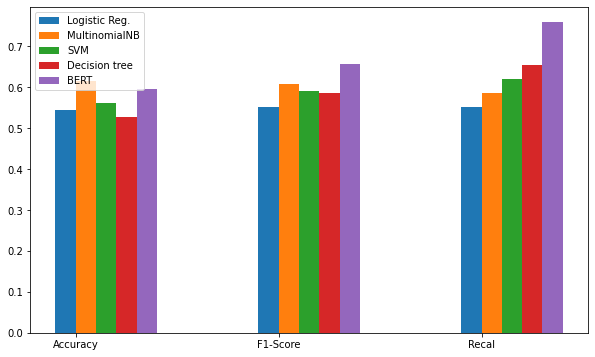

In [96]:
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metricList))
bar_width = 0.1
#b1 = ax.bar(x, accuracyList,width=bar_width, label="Accuracy")
#b2 = ax.bar(x + bar_width, f1Score, width=bar_width, label="F1-Score")
#b3 = ax.bar(x + bar_width+bar_width, recall, width=bar_width, label="Recall")
b1 = ax.bar(x, LR,width=bar_width, label="Logistic Reg.")
b2 = ax.bar(x + bar_width, NB, width=bar_width, label="MultinomialNB")
b3 = ax.bar(x + bar_width+bar_width, SVM, width=bar_width, label="SVM")
b4 = ax.bar(x + bar_width+bar_width+bar_width, TR, width=bar_width, label="Decision tree")
b5 = ax.bar(x + bar_width+bar_width+bar_width+bar_width, BT, width=bar_width, label="BERT")

# Fix the x-axes.
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(metricList)
ax.legend()
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'betweenModelComparison_'+train_test_ratio+'.jpg')

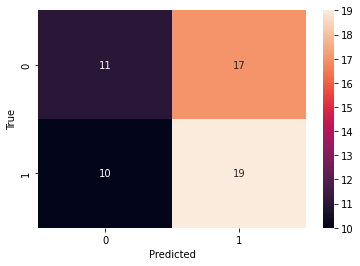

In [69]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm_tree, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'cmTREE_'+train_test_ratio+'.jpg')

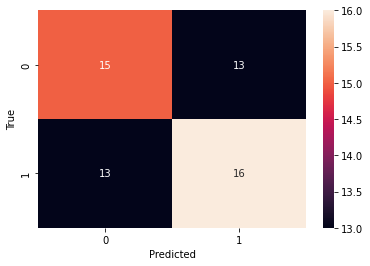

In [70]:
sn.heatmap(cm_lr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'cmLR_'+train_test_ratio+'.jpg')


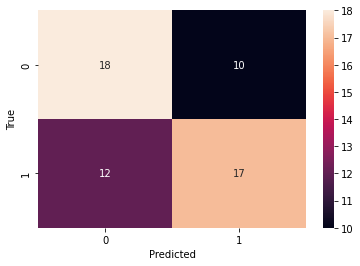

In [71]:
sn.heatmap(cm_nb, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'cmNB_'+train_test_ratio+'.jpg')

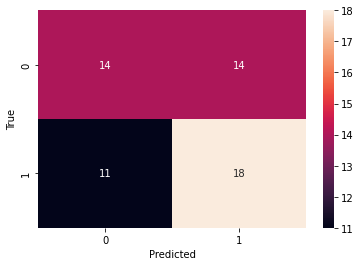

In [72]:
sn.heatmap(cm_svm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'cmSVM_'+train_test_ratio+'.jpg')

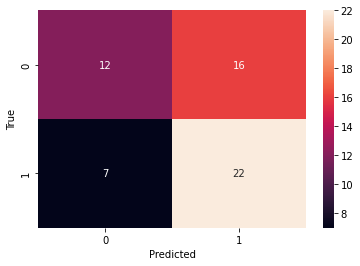

In [73]:
sn.heatmap(cm_BERT, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'cmBERT_'+train_test_ratio+'.jpg')

In [74]:
outputDf_Bert = data.loc[data["clean_text"].isin(X_test.tolist())]

outputDf_Bert['Predicted'] = y_predict_BERT

outputDf_Bert.to_csv('D:/NLP_SentimentA_RTE_Data/Images/'+'BERT_'+train_test_ratio+'.csv', index= True)


C:\Users\tunji\AppData\Local\Temp/ipykernel_13088/1892656747.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outputDf_Bert['Predicted'] = y_predict_BERT


In [75]:
outputDf_LR = data.loc[data["clean_text"].isin(X_test.tolist())]

outputDf_LR['Predicted'] = y_predict_lr

outputDf_LR.to_csv('D:/NLP_SentimentA_RTE_Data/Images/'+'LR_'+train_test_ratio+'.csv', index= True)

C:\Users\tunji\AppData\Local\Temp/ipykernel_13088/3172493880.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outputDf_LR['Predicted'] = y_predict_lr


In [76]:
outputDf_NB = data.loc[data["clean_text"].isin(X_test.tolist())]

outputDf_NB['Predicted'] = y_predict_nb

outputDf_NB.to_csv('D:/NLP_SentimentA_RTE_Data/Images/'+'NB_'+train_test_ratio+'.csv', index= True)

C:\Users\tunji\AppData\Local\Temp/ipykernel_13088/1707437014.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outputDf_NB['Predicted'] = y_predict_nb


In [77]:
outputDf_SVM = data.loc[data["clean_text"].isin(X_test.tolist())]

outputDf_SVM['Predicted'] = y_predict_svm

outputDf_SVM.to_csv('D:/NLP_SentimentA_RTE_Data/Images/'+'SVM_'+train_test_ratio+'.csv', index= True)

C:\Users\tunji\AppData\Local\Temp/ipykernel_13088/1121775420.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outputDf_SVM['Predicted'] = y_predict_svm


In [78]:
outputDf_TREE = data.loc[data["clean_text"].isin(X_test.tolist())]

outputDf_TREE['Predicted'] = y_predict_tree

outputDf_TREE.to_csv('D:/NLP_SentimentA_RTE_Data/Images/'+'TREE_'+train_test_ratio+'.csv', index= True)

C:\Users\tunji\AppData\Local\Temp/ipykernel_13088/1507383083.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outputDf_TREE['Predicted'] = y_predict_tree


In [79]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

data_1 = data.loc[data['Label'] == 1]
data_0 = data.loc[data['Label'] == 0]
desList = ''.join(map(str,data_1['Response'].tolist()))
Un_desList = ''.join(map(str,data_0['Response'].tolist()))

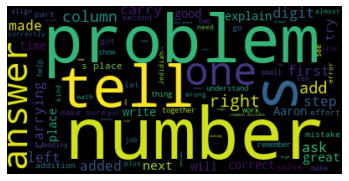

In [80]:
wordcloud=WordCloud().generate(Un_desList)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'Un_desiredResponses_afterLemm_'+train_test_ratio+'.jpg')

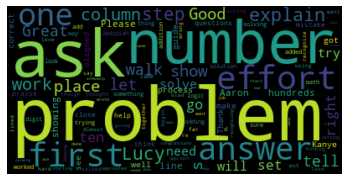

In [81]:
wordcloud=WordCloud().generate(desList)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/'+'desiredResponses_afterLemm_'+train_test_ratio+'.jpg')

In [82]:
filename = 'C:/Users/tunji/CMUProject/SavedModels/'+'bert'+train_test_ratio+'.sav'
pickle.dump(model_BERT, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://0d53667a-41a2-485b-a182-9e04f2aed1b6/assets


INFO:tensorflow:Assets written to: ram://0d53667a-41a2-485b-a182-9e04f2aed1b6/assets


In [83]:
filename = 'C:/Users/tunji/CMUProject/SavedModels/'+'lr'+train_test_ratio+'.sav'
pickle.dump(model_lr, open(filename, 'wb'))

In [84]:
filename = 'C:/Users/tunji/CMUProject/SavedModels/'+'nb'+train_test_ratio+'.sav'
pickle.dump(model_nb, open(filename, 'wb'))

In [85]:
filename = 'C:/Users/tunji/CMUProject/SavedModels/'+'svm'+train_test_ratio+'.sav'
pickle.dump(model_svm, open(filename, 'wb'))

In [86]:
filename = 'C:/Users/tunji/CMUProject/SavedModels/'+'tree'+train_test_ratio+'.sav'
pickle.dump(model_tree, open(filename, 'wb'))

In [87]:
def store_model_metricsAND_test_output(accuracyList, f1_ScoreList, recallList, confMatrixData, modelLabel):

    
    filename = 'D:/NLP_SentimentA_RTE_Data/Images/'+modelLabel+'/'+modelLabel+'10Runs.jpg'
    y_acc_points = np.array(accuracyList)
    y_f1_points = np.array(f1_ScoreList)
    y_recal_points = np.array(recallList)
    plt.plot(y_acc_points, color = 'r', label="Accuracy")
    plt.plot(y_f1_points, color = 'b', label="F1 score")
    plt.plot(y_recal_points, color = 'g', label = "Recall")

    plt.xlabel('Number of runs')
    plt.title(modelLabel)
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [88]:
def train_test_Model_AND_Store_Metrics(X_train_vectors_tfidf, X_test_vectors_tfidf, runNum, modelFunction, modelLabel):
    
    accList=[]
    f1List = []
    recallList=[]
    cmData = []

    for i in range (runNum):
        cm, acc, f1, recall = modelFunction(X_train_vectors_tfidf, X_test_vectors_tfidf, i )
    
        accList.append(acc)
        f1List.append(f1)
        recallList.append(recall)
        cmData.append(cm)
    
    store_model_metricsAND_test_output(accList, f1List, recallList, cmData, modelLabel)
    
    return accList, f1List, recallList, cmData
    

In [89]:
accList_lr, f1List_lr, recallList_lr, cmData_lr=train_test_Model_AND_Store_Metrics(data2, 10, trainAndTest_lr_Model, 'lr')
accList_nb, f1List_nb, recallList_nb, cmData_nb=train_test_Model_AND_Store_Metrics(data2, 10, trainAndTest_nb_Model, 'nb')
accList_svm, f1List_svm, recallList_svm, cmData_svm=train_test_Model_AND_Store_Metrics(data2, 10, trainAndTest_SVM_Model, 'svm')
accList_tree, f1List_tree, recallList_tree, cmData_tree=train_test_Model_AND_Store_Metrics(data2, 10, trainAndTest_tree_Model, 'tree')

NameError: name 'data2' is not defined

In [ ]:
maxI=accList_tree.index(max(accList_tree))

In [ ]:
accList_tree[maxI]

In [ ]:
plt.plot(f1List_lr, color = 'r', label="Linear regression")
plt.plot(f1List_nb, color = 'b', label="Naive bayes")
plt.plot(f1List_svm, color = 'g', label = "SVM")
plt.plot(f1List_tree, color = 'y', label = "Tree")

plt.xlabel('Number of runs')
plt.title('F1-Score Between-Models')
plt.legend()
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/f1score_between_models.jpg')
plt.show()

In [ ]:
plt.plot(accList_lr, color = 'r', label="Linear regression")
plt.plot(accList_nb, color = 'b', label="Naive bayes")
plt.plot(accList_svm, color = 'g', label = "SVM")
plt.plot(accList_tree, color = 'y', label = "Tree")

plt.xlabel('Number of runs')
plt.title('Accuracy Between-Models')
plt.legend()
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/accuracy_between_models.jpg')
plt.show()

In [ ]:
plt.plot(recallList_lr, color = 'r', label="Linear regression")
plt.plot(recallList_nb, color = 'b', label="Naive bayes")
plt.plot(recallList_svm, color = 'g', label = "SVM")
plt.plot(recallList_tree, color = 'y', label = "Tree")

plt.xlabel('Number of runs')
plt.title('Recall Between-Models')
plt.legend()
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/recall_between_models.jpg')
plt.show()

In [ ]:
cmData_lr

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
maxAcc_svm=accList_svm.index(max(accList_svm))
cMatrix_svm = cmData_svm[maxAcc_svm]
sn.heatmap(cMatrix_svm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best SVM.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_svm.jpg')



In [ ]:
maxAcc_lr=accList_lr.index(max(accList_lr))
cMatrix_lr = cmData_lr[maxAcc_lr]
sn.heatmap(cMatrix_lr, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best Linear Regr.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_lr.jpg')



In [ ]:
maxAcc_nb=accList_nb.index(max(accList_nb))
cMatrix_nb = cmData_nb[maxAcc_nb]
sn.heatmap(cMatrix_nb, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best Naive Bayes.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_nb.jpg')



In [ ]:
maxAcc_tree=accList_tree.index(max(accList_tree))
cMatrix_tree = cmData_tree[maxAcc_tree]
sn.heatmap(cMatrix_tree, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix for best Decision Tree.')
plt.savefig('D:/NLP_SentimentA_RTE_Data/Images/cMatrix_4_best_tree.jpg')

In [ ]:
accList_lr.index(max(accList_lr))

In [ ]:
#save the model to disk



  